# Substitution

This notebook compares the predicted substitution rates with various other sets of data, such as 

 - phylofit branch length estimates
 - the number of subsitutions in genes (from Urrichio et al.)
 
The goal is to check that the model is making reasonable predictions in terms of the substitution rate. 

It is exceedingly important that we avoid cirular logic here. For example, the predicted ratchet rates per segment depend on that annotation class, which each have their own DFE estimates.

There are a few checks we can do: 

 - total predicted substitution rate versus observed 
 - spatial patterns of predicted versus observed substitution rates along the chromosome
 - predicted versus observed by feature type
 
There is not a great deal of variance in predicted substitution rates (as we'll see later). It's important that we ensure that the correspondance between predicted and observed isn't just an artifact of densities of the different annotation classes. This wouldn't be entirely an artifact or circular reasoning, but we should ensure the correspondence is good within classes too.

A quick note about the simulations. It is *very* difficult to get good substitution rate estimates to validate the whole-genome substitution rate predictions.

This is because, imagine, for a $N=10,000$ simulation that the subrate is relatively high at 1e-9. For a 10N generations, 

That amounts to,

In [1]:
N = 10_000
10*N*1e-9

0.0001

simulations per basepair.

## Requisites

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
import os
import re
import pickle
import numpy as np
import pandas as pd
from collections import defaultdict
import scipy.stats as stats
import seaborn as sns
from scipy.stats import binned_statistic
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

from bgspy.genome import Genome
from bgspy.data import GenomeData
from bgspy.models import BGSModel
from bgspy.utils import logbins, bin2midpoints, cutbins, bin2pairs, binned_summaries
from bgspy.utils import latex_scientific_notation
from bgspy.utils import corr, mean_ratio, censor, pretty_signif, load_seqlens
from bgspy.utils import read_phylofit, bin_chrom, load_pickle
from bgspy.plots import get_figax, binned_means_plot
from bgspy.nonparametric import KernelRegression, bin_kfolds, kfolds_results

/home/vsb/projects/bprime/bgspy/data.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


In [4]:
plt.show()

In [5]:
plt.rcParams['figure.figsize'] = [5, 3]
plt.rcParams['figure.dpi'] = 200
plt.style.use('./buffalo.mplstyle')
prop_cycle = plt.rcParams['axes.prop_cycle']
COLORS = prop_cycle.by_key()['color']

## Color Settings

Common population colors. We use paired, since in the $R^2$ plots they are paired.

In [6]:
pop_to_num = {'yri': 0, 'ceu': 1, 'chb': 2}

In [7]:
cmap = cm.get_cmap('Paired')
pop_cols = cmap(np.arange(6))

/tmp/ipykernel_33787/3553568411.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Paired')


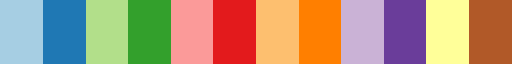

In [8]:
cmap

In [9]:
all_pop_cols = dict()
i = 0
for pop in pop_to_num:
    #plt.scatter(pop, i, c=pop_cols[i+1, :], s=40)
    all_pop_cols[pop] = pop_cols[i+1, :]
    i += 2

## Load Data

In [10]:
seqlens = load_seqlens('../data/annotation/hg38_seqlens.tsv')

 
### Phastcons Priority and CDS Priority Models

This is the main focus since we care about estimating the sub rates for these features.

In [11]:
cds_model = load_pickle('../new_fits/CDS_genes_phastcons__decode__altgrid/CDS_genes_phastcons__decode__altgrid.pkl')
pc_model = load_pickle('../new_fits/phastcons_CDS_genes__decode__altgrid/phastcons_CDS_genes__decode__altgrid.pkl')


cds_6x8_model = load_pickle('../new_fits/CDS_genes_phastcons__decode/CDS_genes_phastcons__decode.pkl')
pc_6x8_model = load_pickle('../new_fits/phastcons_CDS_genes__decode/phastcons_CDS_genes__decode.pkl')

#cadd_model = load_pickle('../new_fits/cadd6__decode__altgrid/cadd6__decode__altgrid.pkl')
#cadd_6x8_model = load_pickle('../new_fits/cadd6__decode/cadd6__decode.pkl')

In [12]:
pc_model.mu_predicts[('yri',
              '1000000',
              'full')][1.5e-8]

,feature,r,r_mu,V,Vm,R,load
0,CDS,1.499700e-08,99.979976,6.347686e-10,6.109335e-12,0.174027,-3.480608e-09
1,gene,1.467280e-08,97.818635,7.202580e-03,7.200205e-05,21.684260,-1.082049e-05
2,other,1.499700e-08,99.980000,1.421320e-09,1.334696e-11,18.587748,-3.717610e-07
3,phastcons,3.092709e-11,0.206181,3.369339e-02,3.278643e-04,0.004521,-8.887037e-07


In [13]:
cds_model.mu_predicts[('yri',
              '1000000',
              'full')][1.5e-8]

,feature,r,r_mu,V,Vm,R,load
0,CDS,1.128747e-08,75.249772,1.644438e-03,1.550866e-05,0.392472,-7.909801e-09
1,gene,1.421068e-08,94.737886,1.569777e-02,1.555064e-04,22.158351,-3.290094e-05
2,other,1.499700e-08,99.980001,7.369183e-10,6.489347e-12,18.587749,-3.717551e-07
3,phastcons,7.689852e-14,0.000513,1.168739e-02,1.160883e-04,0.000003,-6.615893e-12


In [14]:
cds_6x8_model.mu_predicts[('yri', '1000000', 'full')][1.5e-8].groupby('feature').mean()

,r,r_mu,V,Vm,R,load
feature,,,,,,
CDS,5.465308e-09,36.435387,5.685261e-02,5.675815e-03,0.190032,-3.928484e-09
gene,1.443386e-08,96.225728,8.942224e-02,8.889284e-03,22.505757,-1.514105e-05
other,1.499700e-08,99.980001,7.693184e-10,3.407903e-11,18.587749,-3.717550e-07
phastcons,5.683681e-11,0.378912,6.879272e-02,6.492200e-03,0.002363,-2.975031e-10


In [15]:
def prediction_df(model, mu=None):
    dfs = []
    pops = set([p for p, _, _ in model.fits.keys()])
    for pop in pops:
        key = (pop, '1000000', 'full')
        if mu is None:
            if key not in model.predicts:
                continue
            df = model.predicts[key]
        else:
            if key not in model.mu_predicts:
                continue
            df = model.mu_predicts[(pop, '1000000', 'full')][mu]
        fit = model.fits[(pop, '1000000', 'full')]['mbp']
        df['pop'] = pop
        df['mle_mu'] = fit.mle_mu
        df['mle_pi0'] = fit.mle_pi0
        dfs.append(df)
    dpops = pd.concat(dfs)
    dpops['r_mu'] = dpops['r'] / dpops['mle_mu']
    # dpops['width'] = dpops['end'] - dpops['start']
    return dpops

d_cds = prediction_df(cds_model)
d_pc = prediction_df(pc_model)
#d_cadd = prediction_df(cadd_model)

# these are the predictions re-calibrated to a fixed mu of 1.5e-3 (1.3e-8 also available)
pred_mu = 1.5e-8
d_cds_mu = prediction_df(cds_model, mu=pred_mu)
d_pc_mu = prediction_df(pc_model, mu=pred_mu)


d_cds_6x8_mu = prediction_df(cds_6x8_model, mu=pred_mu)
d_pc_6x8_mu = prediction_df(pc_6x8_model, mu=pred_mu)

#d_cadd_mu = prediction_df(pc_model, mu=pred_mu)

Very important note: our Feature Priority model fits poorly, but is better in terms of interpretability. The mutation rate estimate is especially high, and thus our substitution rates are miscalibrated because of this:

In [16]:
{pop: pc_model.fits[(pop, '1000000', 'full')]['mbp'].mle_mu for pop in pop_to_num}

{'yri': 2.0037284154071297e-08,
 'ceu': 1.911701884465589e-08,
 'chb': 1.868851015820453e-08}

In [17]:
{pop: cds_model.fits[(pop, '1000000', 'full')]['mbp'].mle_mu for pop in pop_to_num}

{'yri': 3.348978293993425e-08,
 'ceu': 3.0441269617592445e-08,
 'chb': 3.172164132301829e-08}

This is why we have the re-calibrated predictions off $\mu = 1.3 \times 10^{-8}$.

### Load PhyloFit Branch Length Estimates

The raw phylofit data, see the `Snakefile` for how this is processed.

Note that the alignments are fairly large and between 10 primate species. The regions that can be aligned are likely under more contraint compared to regions that are not alignable. 

In [18]:
import os
import re
from bgspy.utils import read_phylofit

PF_FEATURE_DIR = '../data/phylo/pfests_by_feature/'

rows = list()
with os.scandir(PF_FEATURE_DIR) as it:
    for entry in it:
        if entry.name.endswith('.mod'):
            chrom, feature = re.match(r'(?P<chrom>[^\.]+)\.(?P<feature>\w+)\.mod', entry.name).groups()
            pf = read_phylofit(entry.path)
            # note "None" branches are unlabelled internal branches
            rows.append({**{'chrom': chrom, 'feature': feature}, **{k: v for k, v in pf['branch_lengths'].items() if k is not None}})
            
dpf = pd.DataFrame(rows)
dpf.to_csv("../data/supplementary_data/phylofit_by_feature.tsv", sep='\t', index=False)

#ave_subrates = dpf.groupby('feature').mean().reset_index()
#ave_subrates

dpf['seqlen'] = [seqlens[c] for c in dpf['chrom'].tolist()]
ave_subrates = dpf.groupby('feature').apply(lambda x: np.average(x.hg38, weights=x.seqlen)).reset_index(name='hg38').reset_index()

[Text(0, 0, 'CDS'),
 Text(1, 0, 'neutral'),
 Text(2, 0, 'phastcons'),
 Text(3, 0, 'three_prime_UTR'),
 Text(4, 0, 'five_prime_UTR'),
 Text(5, 0, 'intron'),
 Text(6, 0, 'phastcons_no_gene')]

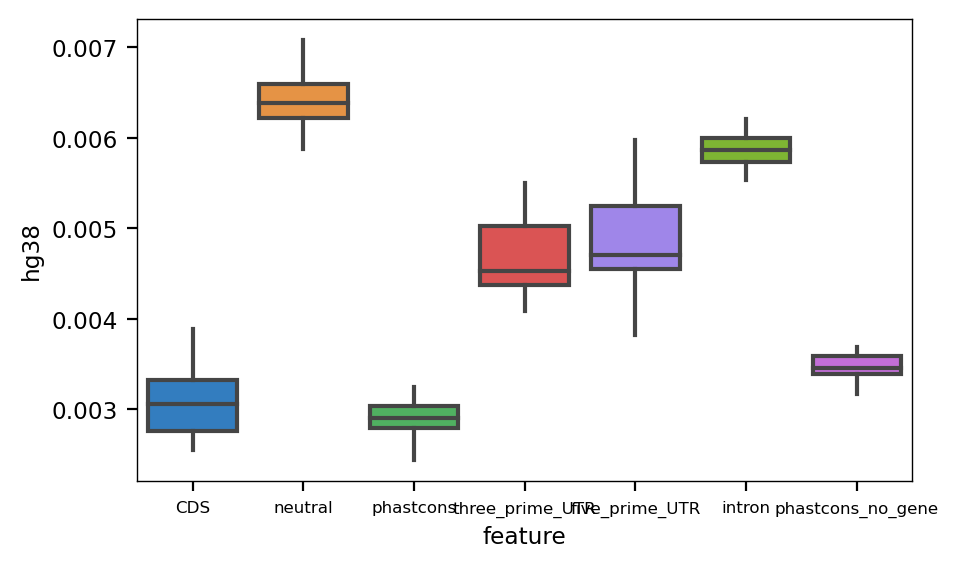

In [19]:
fig, ax = plt.subplots()
sns.boxplot(x='feature', y='hg38', data=dpf, ax=ax)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, fontsize=6)

In [20]:
ave_subrates

,index,feature,hg38
0,0,CDS,0.003253
1,1,five_prime_UTR,0.004831
2,2,intron,0.005901
3,3,neutral,0.006384
4,4,phastcons,0.003164
5,5,phastcons_no_gene,0.003676
6,6,three_prime_UTR,0.004636


In [21]:
# we make a dictionary form for hg38
S = dict(zip(ave_subrates['feature'], ave_subrates['hg38']))
S

{'CDS': 0.0032528586501987433,
 'five_prime_UTR': 0.0048314233244310155,
 'intron': 0.0059009062379961124,
 'neutral': 0.0063836911651855245,
 'phastcons': 0.003163970484989138,
 'phastcons_no_gene': 0.003675999040481652,
 'three_prime_UTR': 0.004636189391619356}

#### Mini look at the PhyloFit files and entries

In [22]:
!cat '../data/phylo/pfests_by_feature/chr8.three_prime_UTR.mod'

ALPHABET: A C G T 
ORDER: 0
SUBST_MOD: HKY85
TRAINING_LNL: -2203810.360001
BACKGROUND: 0.298017 0.202768 0.201547 0.297668 
RATE_MAT:
  -0.887185    0.124470    0.579989    0.182725 
   0.182939   -1.163253    0.123721    0.856593 
   0.857597    0.124470   -1.164792    0.182725 
   0.182939    0.583502    0.123721   -0.890162 
TREE: (ponAbe2:0.0089694,((hg38:0.00458684,(panTro4:0.00160711,panPan1:0.00157617):0.00311549):0.00161618,gorGor3:0.00607908):0.0089694);


In [23]:
pf

{'alphabet': 'A C G T',
 'order': '0',
 'subst_mod': 'HKY85',
 'training_lnl': '-2203810.360001',
 'background': '0.298017 0.202768 0.201547 0.297668',
 'rate': array([[-0.887185,  0.12447 ,  0.579989,  0.182725],
        [ 0.182939, -1.163253,  0.123721,  0.856593],
        [ 0.857597,  0.12447 , -1.164792,  0.182725],
        [ 0.182939,  0.583502,  0.123721, -0.890162]]),
 'tree': '(ponAbe2:0.0089694,((hg38:0.00458684,(panTro4:0.00160711,panPan1:0.00157617):0.00311549):0.00161618,gorGor3:0.00607908):0.0089694);',
 'branch_lengths': {None: 0.00311549,
  'ponAbe2': 0.0089694,
  'hg38': 0.00458684,
  'panTro4': 0.00160711,
  'panPan1': 0.00157617,
  'gorGor3': 0.00607908}}

Just to check we're reading things in right...

### Average Sub rate predictions by feature/pop

### Look at the PhyloFit Rates

In [24]:
cds_mu_ave = dict(zip(d_cds_mu['feature'], d_cds_mu['r']))
cds_mu_ave

pc_mu_ave = dict(zip(d_pc_mu['feature'], d_pc_mu['r']))
cds_mu_ave, pc_mu_ave

({'CDS': 6.477472772347095e-09,
  'gene': 1.425318434963943e-08,
  'other': 1.4997000085617536e-08,
  'phastcons': 9.029680272870394e-14},
 {'CDS': 1.4996997532875883e-08,
  'gene': 1.4467082354900878e-08,
  'other': 1.4996999977415496e-08,
  'phastcons': 5.951376341273661e-13})

In [25]:
# cds_ave = dict(zip(d_cds['feature'], d_cds['r']))
# cds_ave

# pc_ave = dict(zip(d_pc['feature'], d_pc['r']))
# cds_ave, pc_ave

In [26]:
cds_6x8_mu_ave = dict(zip(d_cds_6x8_mu['feature'], d_cds_6x8_mu['r']))

pc_6x8_mu_ave = dict(zip(d_pc_6x8_mu['feature'], d_pc_6x8_mu['r']))
cds_6x8_mu_ave, pc_6x8_mu_ave

({'CDS': 1.464782914340125e-09,
  'gene': 1.4383378678644554e-08,
  'other': 1.4997000174673945e-08,
  'phastcons': 1.4417641692325323e-10},
 {'CDS': 4.1789145289367105e-14,
  'gene': 1.4186942893423907e-08,
  'other': 1.4775507151092322e-08,
  'phastcons': 7.200084424456276e-09})

In [27]:
{f: np.round(100*v / 1.5e-8, 3) for f, v in pc_mu_ave.items()}

{'CDS': 99.98, 'gene': 96.447, 'other': 99.98, 'phastcons': 0.004}

In [28]:
cds_mu_ave['phastcons'] * 100

9.029680272870393e-12

In [29]:
{f: np.round(100*v / 1.5e-8, 3) for f, v in cds_mu_ave.items()}

{'CDS': 43.183, 'gene': 95.021, 'other': 99.98, 'phastcons': 0.001}

## Main Subsitution Fig

In [30]:
S

{'CDS': 0.0032528586501987433,
 'five_prime_UTR': 0.0048314233244310155,
 'intron': 0.0059009062379961124,
 'neutral': 0.0063836911651855245,
 'phastcons': 0.003163970484989138,
 'phastcons_no_gene': 0.003675999040481652,
 'three_prime_UTR': 0.004636189391619356}

In [31]:
{f: np.round(100 * v / S['neutral'], 3) for f, v in S.items()}

{'CDS': 50.956,
 'five_prime_UTR': 75.684,
 'intron': 92.437,
 'neutral': 100.0,
 'phastcons': 49.563,
 'phastcons_no_gene': 57.584,
 'three_prime_UTR': 72.626}

In [32]:
(75.684 + 72.626)/2 # rough estimate is fine for UTRs

74.155

In [33]:
S['CDS']/S['neutral'] , S['phastcons']/S['neutral'] 

(0.5095576471397497, 0.4956333887585845)

In [34]:
(S['phastcons']/S['neutral'] * 100) / 51.23

0.9674670871727201

In [35]:
S['intron']/S['neutral'] , S['five_prime_UTR']/S['neutral'] , S['three_prime_UTR']/S['neutral'] 

(0.9243721360108464, 0.7568385122983317, 0.7262552763992645)

In [176]:
from matplotlib.ticker import FuncFormatter
import matplotlib.lines as mlines

def to_percent(y, position):
    return str(np.round(100 * y, 2)) + '%'

def error_range(x, ymin, ymax, ax, flip=False, text=None, cap_length = 0.1, label=None, **kwargs):
    if flip:
        cap_length = -cap_length
    y = [(ymin_i + ymax_i) / 2 for ymin_i, ymax_i in zip(ymin, ymax)]
    y_err = [(ymax_i - ymin_i) / 2 for ymin_i, ymax_i in zip(ymin, ymax)]
    c = ax.errorbar(x, y,  yerr=y_err, fmt='none', label=label, **kwargs)
      # Adjust as needed
    for xi, yi, yerr_i in zip(x, y, y_err):
        line = mlines.Line2D([xi, xi + cap_length], [yi + yerr_i, yi + yerr_i], c=kwargs.get('c', 'k'))
        ax.add_line(line)
        line = mlines.Line2D([xi, xi + cap_length], [yi - yerr_i, yi - yerr_i], c=kwargs.get('c', 'k'))
        ax.add_line(line)

def pred_range(x, rate, T_low, T_high, gen, ax, **kwargs):
    y = np.array(list(rate))
    ymin = y * T_low / gen
    ymax = y * T_high / gen
    error_range(x, ymin, ymax, ax, **kwargs)


def sub_plot(Sa, pc_mu_ave, cds_mu_ave):
    x, y = np.fromiter(Sa.keys(), 'object'), np.fromiter(Sa.values(), 'float')
    idx = np.argsort(y)
    x, y = x[idx], y[idx]

    fig, ax = plt.subplots()
    ax.plot(x, y, '-o', c='0.22', markersize=8, linewidth=3)
    ax.tick_params(axis='x', which='major', labelsize=7)

    formatter = FuncFormatter(to_percent)

    # Apply the formatter to the y-axis
    ax.yaxis.set_major_formatter(formatter)

    # we need to merge similar features for the X, 
    # so we make a lookup table
    xi = np.arange(len(x))
    lookup = dict(zip(x, xi))
    # join "gene" (=UTR+intron) to UTRs since theyre approx same
    # plot in between the two now
    lookup['gene'] = (lookup['five_prime_UTR'] + lookup['intron'])/2
    lookup['other'] = lookup['neutral'] # all other is ~ neutral

    # get the prediction values phastcons fixed mu
    px = {lookup[l]: v for l, v in pc_mu_ave.items()}
    x = np.fromiter(px.keys(), float)
    pred_range(x-0.1, px.values(), 6e6, 12e6, 29, ax, c='g', label='PhastCons Priority', flip=True)

    # get the prediction values for CDS fixed mu
    px = {lookup[l]: v for l, v in cds_mu_ave.items()}
    x = np.fromiter(px.keys(), float)
    pred_range(x+0.1, px.values(), 6e6, 12e6, 29, ax, label='Feature Priority', c='c')

    # get the prediction values for CDS mle mu
    px = {lookup[l]: v for l, v in cds_mu_ave.items()}
    x = np.fromiter(px.keys(), float)
    #pred_range(x, px.values(), 6e6, 12e6, 29, ax, c='r')

    # # get the prediction values for CDS mle mu
    x = {lookup[l]: v for l, v in pc_mu_ave.items()}
    x = np.fromiter(px.keys(), float)
    #pred_range(x, px.values(), 6e6, 12e6, 29, ax, c='orange')

    #ax.set_ylim(-1e-4, 0.009)
    #ax.semilogy()
    x, y = np.fromiter(S.keys(), 'object'), np.fromiter(S.values(), 'float')
    idx = np.argsort(y)
    x, y = x[idx], y[idx]
    #ax.plot(x, 0.7*y, '-o', c='orange')
    ax.set_ylabel("substitutions/site on human lineage")

    #ax.axhline(0.0056)
    xtick_labs = dict(five_prime_UTR="5' UTR", three_prime_UTR="3' UTR", 
                      phastcons_no_cds_utr='phastcons\nwithout CDS/UTR', phastcons='PhastCons')
    new_labs = [xtick_labs.get(x.get_text(), x.get_text()) for x in ax.get_xmajorticklabels()]

    ax.set_xticklabels(new_labs)
    ax.legend(fontsize=8)


    legend = ax.legend(fontsize=7, title="Annotation Model", title_fontsize=8)


    for handle in legend.legend_handles:
        handle.set_linewidth(3.0)

    ax.set_xlim(-1.3, 6)
    ax.set_xlabel('feature')
    #ax.text(-0.6, 0.0028, "PhyloFit\nestimates", fontsize=7, ha='center')
    return fig, ax
    #ax.semilogy()
    #plt.savefig("../manuscript/figures/subfigure_subsitution.pdf")
    

In [177]:
pc_mu_ave

{'CDS': 1.4996997532875883e-08,
 'gene': 1.4467082354900878e-08,
 'other': 1.4996999977415496e-08,
 'phastcons': 5.951376341273661e-13}

In [178]:
pc_mu_rs_ave = {r.feature: r.r for r in pc_model.mu_predicts[('yri', '1000000', 'sparse')][1.5e-08].itertuples(index=False)}
pc_mu_rs_ave

{'CDS': 1.4996999766805098e-08,
 'gene': 1.490753128651732e-08,
 'phastcons': 9.20122995504761e-09}

In [179]:
10e6  * pc_mu_rs_ave['phastcons'] / 29

0.003172837915533659

/tmp/ipykernel_33787/3454168234.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labs)
/tmp/ipykernel_33787/410080188.py:52: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  old_handles = old_legend.legendHandles


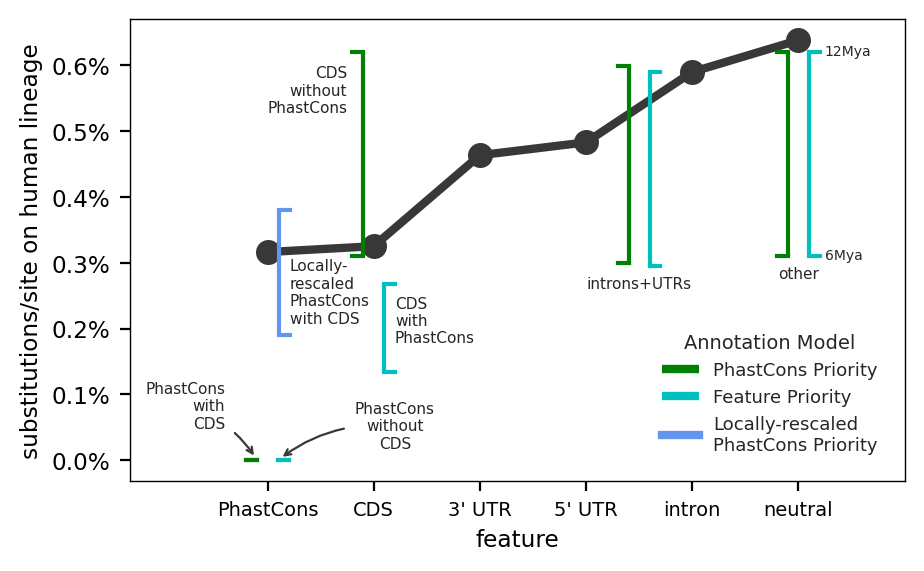

In [192]:
# the obs. subs dists
Sa = dict(S)
# simplify plot;  this doesn't add anything
Sa.pop('phastcons_no_gene')

fig, ax = sub_plot(Sa, pc_mu_ave, cds_mu_ave)

fs = 5.5

ax.text(3.5, 0.0028, "introns+UTRs", ha='center', va='top', fontsize=fs)
ax.text(5, 0.00295, "other", ha='center', va='top', fontsize=fs)
ax.text(1.2, 0.0025, "CDS\nwith\nPhastCons", ha='left', va='top', fontsize=fs)
ax.text(0.75, 0.006, "CDS\nwithout\nPhastCons", ha='right', va='top', fontsize=fs)

#ax.text(-0.25, 0.00178, "phastcons\nwith\nCDS", ha='center', va='top', fontsize=fs)
lw = 0.8
# ax.annotate(f"PhastCons\nwith\nCDS\n{latex_scientific_notation(100 * pc_mu_ave['phastcons'])}%",
#             xy=(-0.1, pc_mu_ave['phastcons']),
#             arrowprops=dict(
#                     arrowstyle='->', connectionstyle="arc3,rad=-0.2",  color='0.22',linewidth=lw),
#             xytext=(-0.5, 0.00178), ha='center', va='top', fontsize=fs)

ax.annotate(f"PhastCons\nwith\nCDS",
            xy=(-0.1, pc_mu_ave['phastcons']),
            arrowprops=dict(
                    arrowstyle='->', connectionstyle="arc3,rad=-0.2",  color='0.22',linewidth=lw),
            xytext=(-0.4, 0.0012), ha='right', va='top', fontsize=fs)


# ax.annotate(f"PhastCons\nwithout\nCDS\n{latex_scientific_notation(100 * cds_mu_ave['phastcons'])}%",
#             xy=(0.1, cds_mu_ave['phastcons']),
#             arrowprops=dict(
#                     arrowstyle='->', connectionstyle="arc3,rad=0.2", color='0.22', linewidth=lw),
#             xytext=(1.2, 0.001), ha='center', va='top', fontsize=fs)

ax.annotate(f"PhastCons\nwithout\nCDS",
            xy=(0.1, cds_mu_ave['phastcons']),
            arrowprops=dict(
                    arrowstyle='->', connectionstyle="arc3,rad=0.2", color='0.22', linewidth=lw),
            xytext=(1.2, 0.0009), ha='center', va='top', fontsize=fs)


pred_range([0.11], [pc_mu_rs_ave['phastcons']], 6e6, 12e6, 29, ax, c='cornflowerblue')
ax.text(5.25, 0.00615, "12Mya", fontsize=5, ha='left')
ax.text(5.25, 0.00305, "6Mya", fontsize=5, ha='left')

old_legend = plt.legend()
new_legend_entry = mlines.Line2D([], [], color='cornflowerblue', linewidth=0,
                                 label='Locally-rescaled\nPhastCons Priority')

if old_legend:
    old_handles = old_legend.legendHandles
    old_labels = [t.get_text() for t in old_legend.texts]

    handles = old_handles + [new_legend_entry]
    labels = old_labels + [new_legend_entry.get_label()]

# create the new legend
leg = ax.legend(handles=handles, labels=labels, fontsize=6.5, title="Annotation Model", title_fontsize=7)

for handle in leg.legend_handles:
    handle.set_linewidth(3.0)

# ax.annotate(f"Locally-Rescaled\nPhastCons\nwith CDS",
#             xy=(0.1, 0.0005 + (10e6 / 29 * pc_mu_rs_ave['phastcons'])),
#             arrowprops=dict(
#                     arrowstyle='->', connectionstyle="arc3,rad=0.2", color='0.22', linewidth=lw),
#             xytext=(-0.6, 0.005), ha='center', va='top', fontsize=fs)

ax.text(0.21, -0.00011 + (10e6 / 29 * pc_mu_rs_ave['phastcons']),
        "Locally-\nrescaled\nPhastCons\nwith CDS", ha='left', va='top', fontsize=fs)

    
plt.savefig('../manuscript/figures/figure_7.pdf')

In [181]:
S['phastcons']/S['neutral']

0.4956333887585845

In [182]:
# in the phastcons paper, human conserved/non-conserved branch length ratio is
0.071 / 0.217

0.32718894009216587

So these estimates from PhyloFit seem reasonable.

In [36]:
cds_mu_ave['CDS'] / pc_mu_ave['CDS']

0.4120966114093439

/tmp/ipykernel_54332/1837192120.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labs)


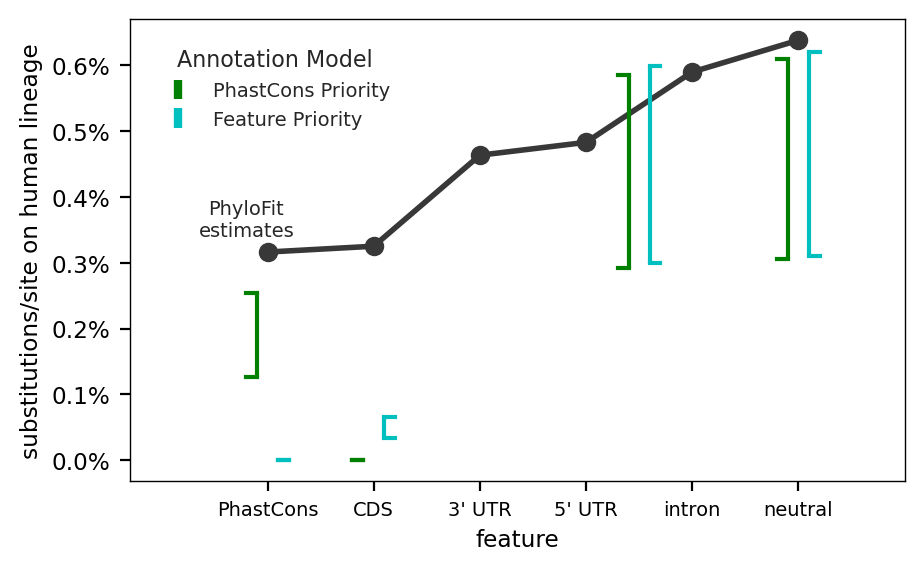

In [37]:
# for completeness, the strong sel grid
fig, ax = sub_plot(Sa, pc_6x8_mu_ave, cds_6x8_mu_ave)

dn/ds ratio in humans is dn/ds=0.14, 14% AA subs neutral (from Pritchard book).

In [38]:
S['CDS']/S['neutral'], S['phastcons']/S['neutral']

(0.5095576471397497, 0.4956333887585845)

In [39]:
dfg = cds_model.mu_predicts[('yri', '1000000','full')][1.5e-8].groupby('feature').mean()
dfg.reset_index()

/tmp/ipykernel_54332/3759102991.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfg = cds_model.mu_predicts[('yri', '1000000','full')][1.5e-8].groupby('feature').mean()


,feature,r,r_mu,V,Vm,R,load,mle_mu,mle_pi0
0,CDS,1.128747e-08,75.249772,1.644438e-03,1.550866e-05,0.392472,-7.909801e-09,3.348978e-08,0.001441
1,gene,1.421068e-08,94.737886,1.569777e-02,1.555064e-04,22.158351,-3.290094e-05,3.348978e-08,0.001441
2,other,1.499700e-08,99.980001,7.369183e-10,6.489347e-12,18.587749,-3.717551e-07,3.348978e-08,0.001441
3,phastcons,7.689852e-14,0.000513,1.168739e-02,1.160883e-04,0.000003,-6.615893e-12,3.348978e-08,0.001441


## Predictions of Load and Fitness Variation

In [40]:
cds_model.mu_predicts[('yri', '1000000', 'full')]

{1.5e-08:      feature             r       r_mu             V            Vm          R  \
 0        CDS  1.128747e-08  75.249772  1.644438e-03  1.550866e-05   0.392472   
 1       gene  1.421068e-08  94.737886  1.569777e-02  1.555064e-04  22.158351   
 2      other  1.499700e-08  99.980001  7.369183e-10  6.489347e-12  18.587749   
 3  phastcons  7.689852e-14   0.000513  1.168739e-02  1.160883e-04   0.000003   
 
            load  pop        mle_mu   mle_pi0  
 0 -7.909801e-09  yri  3.348978e-08  0.001441  
 1 -3.290094e-05  yri  3.348978e-08  0.001441  
 2 -3.717551e-07  yri  3.348978e-08  0.001441  
 3 -6.615893e-12  yri  3.348978e-08  0.001441  }

In [41]:
def load_Vm_stats(df, mu):
    V = df['V'].values.sum()
    Vm = df['Vm'].values.sum()
    load = df['load'].values.sum()
    ave_r = np.average(df['r'].values, weights=df['seglen'])
    return dict(V=V, Vm=Vm, load=load, ave_r=100*(ave_r/mu))

In [42]:
mu = 1.5e-8

for pop in pop_to_num:
    print((pop, load_Vm_stats(pc_model.mu_predicts[(pop, '1000000','full')][mu], mu=mu)))

KeyError: 'seglen'

In [ ]:

for pop in pop_to_num:
    print((pop, load_Vm_stats(pc_6x7_model.mu_predicts[(pop, '1000000','full')][mu], mu=mu)))

In [ ]:
for pop in pop_to_num:
    print((pop, load_Vm_stats(pc_model.mu_predicts[(pop, '1000000','full')][1.5e-8])))

In [ ]:
cds_model.mu_predicts[('yri', '1000000', 'full')][1.5e-8].groupby('feature').sum()

In [ ]:
cds_sum = cds_model.mu_predicts[('yri', '1000000', 'full')][1.5e-8].groupby('feature').sum()
cds_sumstats = cds_sum.sum()

In [ ]:
keep = 'V', 'Vm', 'load'
cds_sumstats_dict = {x.index: x.stats for x in cds_sumstats.reset_index(name='stats').itertuples() if x.index in keep}
cds_sumstats_dict

In [ ]:
(1-np.exp(-1.5517030346484817e-05))*100

In [ ]:
from bgspy.recmap import RecMap
rm = RecMap('../data/fit_annotation/decode_2019_map.txt', seqlens)

auto_map_length = sum({c: x.rate[-1] for c, x in rm.cum_rates.items() if c.replace('chr', '') in map(str, range(2, 23))}.values())

def SC98(C2, Vm, L):
    Z = Vm/C2
    return np.exp(-C2/ ((1-Z)*L))
                  
SC98(cds_sumstats_dict['V'], cds_sumstats_dict['Vm'], auto_map_length)                